# Random Forest Classifier (Part 2)

We will be cleaning data and handling outlier and see the model performance
Authors:
- Nooruddin Shaikh
- Milind Sai
- Saurabh Jejurkar
- Kartik Bhargav

![AQI Look Up Table](http://www.sparetheair.com/assets/aqi/Ozone2017.png)

From the above table, we can see any value greater than 300 upto 500 is Hazardous or Severe. Most of the countries have a AQi range from 0 to 500. But in our data many of the AQI values is above 500. Let's replace all the AQI value greater than 500 with 500 and see the model performance.

In [2]:
#Importing Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from  sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
from datetime import datetime
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
data = pd.read_csv("Data/final_data.csv")
data.head()

,PM2.5,NO2,CO,SO2,O3,AQI
0,83.13,28.71,6.93,49.52,59.76,209.0
1,79.84,28.68,13.85,48.49,97.07,328.0
2,94.52,32.66,24.39,67.39,111.33,514.0
3,135.99,42.08,43.48,75.23,102.70,782.0
4,178.33,35.31,54.56,55.04,107.38,914.0


In [4]:
data["AQI"].values[data["AQI"] > 499] = 500

In [5]:
data

,PM2.5,NO2,CO,SO2,O3,AQI
0,83.13,28.71,6.93,49.52,59.76,209.0
1,79.84,28.68,13.85,48.49,97.07,328.0
2,94.52,32.66,24.39,67.39,111.33,500.0
3,135.99,42.08,43.48,75.23,102.70,500.0
4,178.33,35.31,54.56,55.04,107.38,500.0
...,...,...,...,...,...,...
22613,15.02,25.06,0.47,8.55,23.30,41.0
22614,24.38,26.06,0.52,12.72,30.14,70.0
22615,22.91,29.53,0.48,8.42,30.96,68.0
22616,16.64,29.26,0.52,9.84,28.30,54.0


Here we will first split our data into 95% and 5%. The 5% data will be unseen and hidden or separated. Then from that 95% we will again split the data into 80% and 20% as a train and test split. here are implementing custom Cross validation to avoid Data Leakages.

In [6]:
#Splitting data as X and y
X = data.iloc[:, :-1] #Independent features
y = data.iloc[:, -1] #Dependent feature

In [7]:
#Splitting and separating 5% data and making it as unseen
X_train_unseen, X_test_unseen, y_train_unseen, y_test_unseen = train_test_split(X, y, test_size=0.05,random_state=1)
len(X_train_unseen),len(X_test_unseen)

(21487, 1131)

In [8]:
# Splitting that 95% data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_train_unseen, y_train_unseen, test_size=0.20,random_state=1)

In [9]:
# Fitting Model without any tunning
model = RandomForestRegressor(n_estimators = 200, random_state = 0)
model = model.fit(X_train, y_train)
prediction = model.predict(X_test)

print("Coefficient of Determination (R^2) for train dataset: ", model.score(X_train, y_train))
print("Coefficient of Determination (R^2) for test dataset: ", model.score(X_test, y_test))

print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

Coefficient of Determination (R^2) for train dataset:  0.9878910757554696
Coefficient of Determination (R^2) for test dataset:  0.9165444529936397
MAE: 20.956891577477897
MSE: 1067.226112075384
RMSE: 32.6684268380861


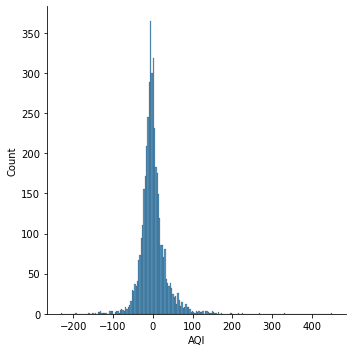

In [10]:
sns.displot(y_test - prediction)

The model is overfitted with 98.7% accuracy on trining but 91.6% on testing. Let's tune the hyperparameter and see if the model can be generalized

# After Hyper Parameter Tuning

In [11]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=18)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10,12]
params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

In [12]:
rf = RandomForestRegressor()
tuned_model = RandomizedSearchCV(rf, params, scoring='neg_mean_squared_error', 
                            cv=5, n_iter=20, random_state=43, n_jobs=-1)

In [13]:
tuned_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10, 12],
                                        'n_estimators': [100, 164, 229, 294,
                                                         358, 423, 488, 552,
                                                         617, 682, 747, 811,
                                                         876, 941, 1005, 1070,
                                                         1135, 1200]},
                   random_state=43, scoring='neg_mean_squared_error')

In [14]:
#Printing Best Parameter during tunning
print(tuned_model.best_estimator_)

RandomForestRegressor(max_depth=25, max_features='sqrt', n_estimators=552)


In [15]:
# Now using the best parameter and predicting
best_rf = RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=552)

In [16]:
best_rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=552)

In [17]:
print("Coefficient of Determination (R^2) for train dataset: ", best_rf.score(X_train, y_train))
print("Coefficient of Determination (R^2) for test dataset: ", best_rf.score(X_test, y_test))

Coefficient of Determination (R^2) for train dataset:  0.9177549646440788
Coefficient of Determination (R^2) for test dataset:  0.9097675650488165


# Predictions

In [19]:
X_test_unseen.head()

,PM2.5,NO2,CO,SO2,O3
14349,38.82,26.56,0.82,10.25,20.06
12364,63.58,40.25,0.23,27.84,50.72
19768,62.33,2.60,0.59,7.46,29.58
8955,118.43,84.21,0.89,37.55,39.59
4563,37.67,37.32,1.06,7.06,34.92


In [21]:
y_test_unseen.head()

14349     74.0
12364    141.0
19768    111.0
8955     421.0
4563      84.0
Name: AQI, dtype: float64

In [24]:
print(best_rf.predict([[38.82,26.56,0.82,10.25,20.06]]))
print(best_rf.predict([[63.58,40.25,0.23,27.84,50.72]]))
print(best_rf.predict([[62.33,2.60,0.59,7.46,29.58]]))
print(best_rf.predict([[118.43,84.21,0.89,37.55,39.59]]))
print(best_rf.predict([[37.67,37.32,1.06,7.06,34.92]]))

[91.19247364]
[135.31602296]
[116.09168436]
[306.4990801]
[100.82184941]


# Insights
- After handling outliers, we can see the improvement in the model.
- Now the model is giveing 91.7% for training and 90.9% as testing data.
- So this model is the best we have achieved.

In [25]:
import pickle
with open("model.pkl","wb") as file:
    pickle.dump(best_rf,file)